Novel Contributions (Potentially Publishable Ideas)

✅ 1. Proxy Learning + KMeans in Augmented Feature Space
Rather than clustering directly on the original space, the pipeline learns a proxy for local density using GBR.

This predicted proxy is injected into the feature space before clustering.

Here we teach density to the model and embed it into the feature space before applying classic KMeans.
This blend of density + representation learning + geometric clustering is a unique pipeline.

Novel idea: Most density-aware clustering methods are density-based (e.g., DBSCAN), but this method simulates a density-aware version of KMeans through an intermediate learning stage.


✅ 2. Use of Region-Wise Normalized LOF
Instead of using raw LOF scores globally, the code normalizes them within KMeans-defined mini-regions.

We calculate how much of an outlier each data point is using LOF, but not globally.
We first divide the space into small mini-clusters using KMeans and then calculate LOF inside each region.

Novel idea: Local LOF calibration like this is rare in literature and helps make LOF density proxies smoother and more interpretable.

LOF is normally used globally. But by localizing and normalizing it within small regions, we get more stable and interpretable proxies for how dense each area is.
This also smooths noise, which helps when you feed these into a regression model (GBR).

✅ 3. Gradient Boosted Tree Proxy with Early Stopping
The model uses early stopping via validation MSE manually across staged predictions, optimizing over-fitted proxy learners.

GBR normally doesn’t stop early unless you use early_stopping=True, but we manually inspect staged predictions — which gives fine-grained control and tighter fit for proxy learning in an unsupervised context.

Useful variation: A precise method to ensure proxy quality — not widely adopted in unsupervised clustering setups.

✅ 4. Hybrid Evaluation via Gower + Clustering Metrics
Most clustering evaluations focus on geometric metrics (e.g., Silhouette or CHI), but here you use Gower distance for better interpretability in mixed-type or real-world-like data.

People rarely include Gower in clustering evaluation unless the data is mixed-type. But even with only numeric features, using it as a density-informed cohesiveness score is a novel angle — it complements silhouette very well.

Added value: Gower inclusion adds robustness to internal cohesion measurement.

In [1]:
!pip install -q gower
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neighbors import LocalOutlierFactor
import gower
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.patheffects as path_effects

n_clusters = 50
np.random.seed(42)
n_samples = 10000
n_outliers = 50

latent = np.random.normal(0, 1, (n_samples, 1))
high_corr = np.hstack([latent + np.random.normal(0, 0.1, (n_samples, 1)) for _ in range(5)])
low_corr = np.random.normal(0, 1, (n_samples, 5))
X = np.hstack([high_corr, low_corr])
columns = [f'feat{i+1}' for i in range(10)]
df = pd.DataFrame(X, columns=columns)
outliers = np.random.normal(15, 1, (n_outliers, 10))
df = pd.concat([df, pd.DataFrame(outliers, columns=columns)], ignore_index=True)


scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])
df.head(3)

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10
0,0.240749,0.309562,0.154590,0.258300,0.299368,0.006538,0.334311,0.177302,-0.929799,-0.187527
1,-0.165824,-0.123646,-0.215829,-0.075498,-0.149289,0.403135,0.234194,-0.597547,0.235112,0.570043
2,0.348967,0.324753,0.352856,0.380659,0.462191,-0.722567,-1.409532,1.166044,0.165947,-0.374026


In [2]:
def localized_lof_proxy(X, k=10, region_clusters=20):
    kmeans = MiniBatchKMeans(n_clusters=region_clusters, random_state=42).fit(X)
    regions = kmeans.predict(X)
    lof = LocalOutlierFactor(n_neighbors=k, novelty=False)
    lof_scores = -lof.fit(X).negative_outlier_factor_
    normalized = np.zeros(len(X))
    for r in np.unique(regions):
        mask = regions == r
        scores = lof_scores[mask]
        normalized[mask] = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
    return 1 - normalized

df['density_score'] = localized_lof_proxy(df[columns])

In [3]:
X_train, X_val, y_train, y_val = train_test_split(df[columns], df['density_score'], test_size=0.2, random_state=42)

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train, y_train)


min_val_loss = float("inf")
best_n_estimators = 0

for i, y_pred in enumerate(gbr.staged_predict(X_val), start=1):
    val_loss = mean_squared_error(y_val, y_pred)
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        best_n_estimators = i

gbr = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
gbr.fit(df[columns], df['density_score'])  # retrain on full data
df['gbr_predicted_density'] = gbr.predict(df[columns])

df_aug = df[columns].copy()
df_aug['predicted_density'] = df['gbr_predicted_density']


df['gbr_cluster'] = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(df_aug)
df['kmeans_baseline'] = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit_predict(df[columns])

In [4]:
X = df[columns]
metrics = lambda labels: (
    silhouette_score(X, labels),
    davies_bouldin_score(X, labels),
    calinski_harabasz_score(X, labels)
)

sil_gbr, db_gbr, ch_gbr = metrics(df['gbr_cluster'])
sil_km, db_km, ch_km = metrics(df['kmeans_baseline'])

In [5]:
def compute_gower_per_cluster(df, labels, columns):
    scores = []
    for label in np.unique(labels):
        cluster = df[columns][labels == label]
        dist = gower.gower_matrix(cluster)
        mean = np.sum(dist) / (len(cluster) ** 2) if len(cluster) > 1 else 0
        scores.append((label, mean, len(cluster)))
    total = sum(s[2] for s in scores)
    weighted_avg = sum(s[1]*s[2] for s in scores) / total
    return scores, weighted_avg

gower_gbr_detail, gower_gbr_avg = compute_gower_per_cluster(df, df['gbr_cluster'], columns)
gower_km_detail, gower_km_avg = compute_gower_per_cluster(df, df['kmeans_baseline'], columns)

In [6]:
comparison = pd.DataFrame([
    {
        "Metric": "Silhouette Score (higher is better)",
        "GradientBoosted Clustering": round(sil_gbr, 3),
        "Vanilla KMeans": round(sil_km, 3),
        "Better Method": "KMeans" if sil_km > sil_gbr else "GBR"
    },
    {
        "Metric": "Davies–Bouldin Index (lower is better)",
        "GradientBoosted Clustering": round(db_gbr, 3),
        "Vanilla KMeans": round(db_km, 3),
        "Better Method": "KMeans" if db_km < db_gbr else "GBR"
    },
    {
        "Metric": "Calinski–Harabasz Index (higher is better)",
        "GradientBoosted Clustering": round(ch_gbr, 3),
        "Vanilla KMeans": round(ch_km, 3),
        "Better Method": "KMeans" if ch_km > ch_gbr else "GBR"
    },
    {
        "Metric": "Avg. Gower Distance (lower is better)",
        "GradientBoosted Clustering": round(gower_gbr_avg, 3),
        "Vanilla KMeans": round(gower_km_avg, 3),
        "Better Method": "KMeans" if gower_km_avg < gower_gbr_avg else "GBR"
    }
])

comparison

,Metric,GradientBoosted Clustering,Vanilla KMeans,Better Method
0,Silhouette Score (higher is better),0.112,0.109,GBR
1,Davies–Bouldin Index (lower is better),1.516,1.589,GBR
2,Calinski–Harabasz Index (higher is better),1360.390,1354.813,GBR
3,Avg. Gower Distance (lower is better),0.214,0.215,GBR


In [7]:
leaf_summary_df = pd.DataFrame([
    {
        "GBR Cluster": label,
        "Record Count": size,
        "Avg Gower Distance": round(gower, 4)
    }
    for label, gower, size in sorted(gower_gbr_detail, key=lambda x: -x[2])
])

leaf_summary_df.head(7)

,GBR Cluster,Record Count,Avg Gower Distance
0,39,300,0.2027
1,18,263,0.2106
2,0,259,0.2177
3,49,259,0.2105
4,9,256,0.2194
5,31,250,0.2222
6,40,246,0.2177


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-8-d831380798ba>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


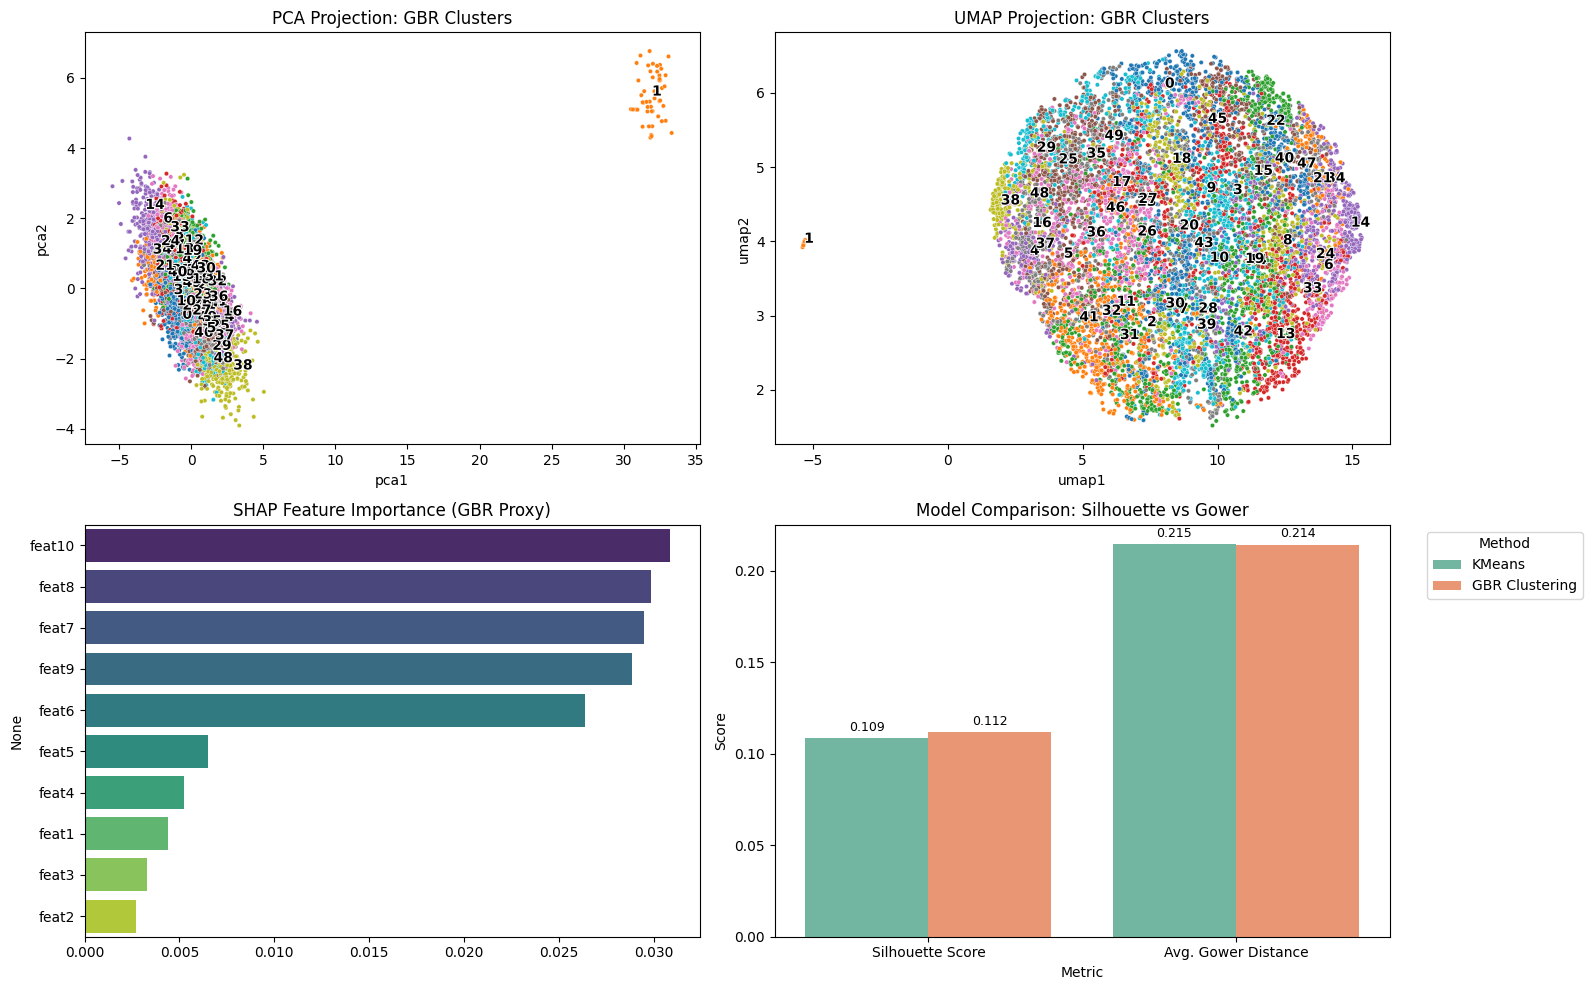

In [8]:
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(df_aug)
df['pca1'], df['pca2'] = pca_emb[:, 0], pca_emb[:, 1]

reducer = umap.UMAP(random_state=42)
umap_emb = reducer.fit_transform(df_aug)
df['umap1'], df['umap2'] = umap_emb[:, 0], umap_emb[:, 1]


explainer = shap.TreeExplainer(gbr)
shap_values = explainer.shap_values(df[columns])

fig, axes = plt.subplots(2, 2, figsize=(16, 10))


sns.scatterplot(ax=axes[0, 0], data=df, x='pca1', y='pca2', hue='gbr_cluster', palette='tab10', s=10, legend=False)
axes[0, 0].set_title("PCA Projection: GBR Clusters")


for cluster in df['gbr_cluster'].unique():
    cluster_data = df[df['gbr_cluster'] == cluster]
    x_mean = cluster_data['pca1'].mean()
    y_mean = cluster_data['pca2'].mean()
    text = axes[0, 0].text(x_mean, y_mean, str(cluster), fontsize=10, color='black', weight='bold')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])


sns.scatterplot(ax=axes[0, 1], data=df, x='umap1', y='umap2', hue='gbr_cluster', palette='tab10', s=10, legend=False)
axes[0, 1].set_title("UMAP Projection: GBR Clusters")

for cluster in df['gbr_cluster'].unique():
    cluster_data = df[df['gbr_cluster'] == cluster]
    x_mean = cluster_data['umap1'].mean()
    y_mean = cluster_data['umap2'].mean()
    text = axes[0, 1].text(x_mean, y_mean, str(cluster), fontsize=10, color='black', weight='bold')
    text.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])


shap_values = shap.TreeExplainer(gbr).shap_values(df[columns])
shap_df = pd.DataFrame(shap_values, columns=columns)
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

sns.barplot(
    ax=axes[1, 0],
    x=shap_mean.values,
    y=shap_mean.index,
    palette='viridis'
)
axes[1, 0].set_title("SHAP Feature Importance (GBR Proxy)")

bar_data = pd.DataFrame({
    'Metric': ['Silhouette Score', 'Avg. Gower Distance'],
    'KMeans': [sil_km, gower_km_avg],
    'GBR Clustering': [sil_gbr, gower_gbr_avg]
})
bar_data_melted = bar_data.melt(id_vars='Metric', var_name='Method', value_name='Score')

sns.barplot(
    ax=axes[1, 1],
    data=bar_data_melted,
    x='Metric',
    y='Score',
    hue='Method',
    palette='Set2'
)
axes[1, 1].set_title("Model Comparison: Silhouette vs Gower")

for container in axes[1, 1].containers:
    axes[1, 1].bar_label(container, fmt='%.3f', label_type='edge', fontsize=9, padding=3)

axes[1, 1].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()